Find background spectrum from xyY specification
===============================================

In [1]:
import sys
sys.path.insert(0, '../')
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from silentsub.device import StimulationDevice
from silentsub.plotting import stim_plot


sns.set_context('notebook')
sns.set_style('whitegrid')

In [2]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)

Plot the gamut of the device
----------------------------

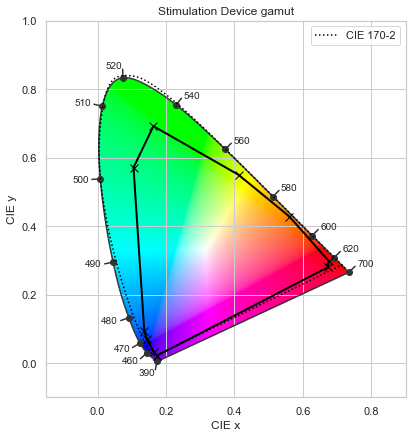

In [3]:
_ = device.plot_gamut()

Requested LMS: [ 0.90570028  0.71772948  0.204594  ]
Solution LMS: [ 0.90570038  0.71772937  0.20459405]


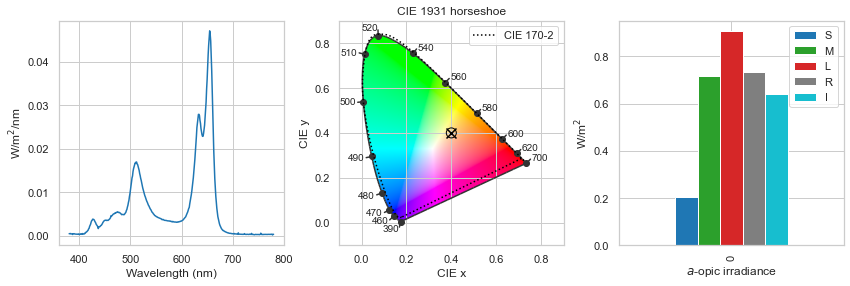

In [4]:
import numpy as np

from scipy.optimize import basinhopping, Bounds, minimize
from colour.plotting import plot_chromaticity_diagram_CIE1931

from silentsub.colorfunc import xyY_to_LMS, LMS_to_xyY, xyY_to_XYZ


# The background finding problem
class FindBackground:
    def __init__(self, xyY):
        self.lms = xyY_to_LMS(xyY)
        
    def objective_function(self, x0):
        aopic = device.predict_multiprimary_aopic(x0)
        return sum(pow(self.lms - aopic[['L','M','S']].to_numpy()[0], 2))

# Requested background 
requested_xyY = [.4, .4, 600.] 
fb = FindBackground(requested_xyY)

# Do optimisation
x0 = np.random.rand(1, device.nprimaries)[0]
bounds = Bounds(np.ones((device.nprimaries))*0,
                np.ones((device.nprimaries))*1)
result = minimize(fun=fb.objective_function, x0=x0, bounds=bounds, options={'maxiter': 1000})

# Get the LMS of solution and print
solution_lms = device.predict_multiprimary_aopic(result.x)[['L','M','S']].values[0]
print(f'Requested LMS: {fb.lms}')
print(f'Solution LMS: {solution_lms}')

# Plot
fig, axs = stim_plot()

# Plot the spectrum
device.predict_multiprimary_spd(result.x).T.plot(ax=axs[0], legend=False)

# Plot solution on horseshoe
solution_xyY = LMS_to_xyY(solution_lms)
axs[1].scatter(x=requested_xyY[0], y=requested_xyY[1], s=100, marker='o', facecolors='none', edgecolors='k', label='Requested')
axs[1].scatter(x=solution_xyY[0], y=solution_xyY[1], s=100, c='k', marker='x', label='Solution')

# Plot aopic irradiances
device_ao = device.predict_multiprimary_aopic(result.x)
device_ao.plot(kind='bar', color=device.aopic_colors, ax=axs[2]);


In [5]:
ao = device_ao.melt(var_name='opic', value_name='W/m2').reset_index()
ao

,index,opic,W/m2
0,0,S,0.204594
1,1,M,0.717729
2,2,L,0.905700
3,3,R,0.733764
4,4,I,0.638640


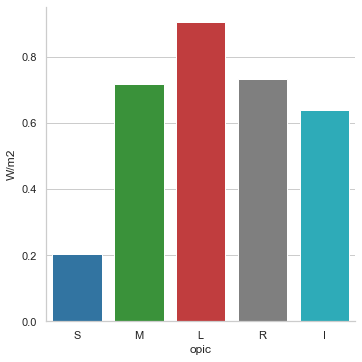

In [6]:
sns.catplot(data=ao, y='W/m2', x='opic', kind='bar', palette=device.aopic_colors)